In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer, HookedTransformerConfig, utils
import random
import circuitsvis as cv
from fancy_einsum import einsum

import pandas as pd
import plotly.express as px

In [2]:
# model parameter constants
N_LAYERS = 2
N_HEADS = 2
D_MODEL = 32
D_HEAD = 32
D_MLP = None
D_VOCAB = 66
SEED = 123
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
MAX_DIGITS = 5
NUM_DIGITS = 2
CTX_LEN = MAX_DIGITS * 3 + 3

In [4]:
def line(tensor, line_labels=None, yaxis="", xaxis="", **kwargs):
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.detach().numpy()
    
    df = pd.DataFrame({
        xaxis: np.arange(len(tensor)),
        yaxis: tensor
    })
    
    fig = px.line(df, x=xaxis, y=yaxis, labels={xaxis: xaxis, yaxis: yaxis}, **kwargs)
    
    if line_labels:
        for c, label in enumerate(line_labels):
            fig.data[c].name = label

    fig.show()

In [5]:
def generate_number_with_variable_length(max_digits):
    num_digits = random.randint(1, max_digits)
    if num_digits == 1:
        return random.randint(0, 9), num_digits 
        return random.randint(10**(num_digits-1), 10**num_digits - 1), num_digits

def generate_data(n, seen, training=True):
    # random.seed(42 if training else 100)
    tokens = []
    target = []

    for _ in range(n):
        curr = []
        answer = ""
        
        # a, len_a = (generate_number_with_variable_length(MAX_DIGITS))
        # b, len_b = (generate_number_with_variable_length(MAX_DIGITS))

        # if training:
        #     seen.add((a, b))
        #     seen.add((b, a))

        # if not training:
        #     while (a, b) in seen or (b, a) in seen:
        #         a, len_a = (generate_number_with_variable_length(MAX_DIGITS))
        #         b, len_b = (generate_number_with_variable_length(MAX_DIGITS))
        a = random.randint(0, 99999)
        b = random.randint(0, 99999)
        len_a = len(str(a))
        len_b = len(str(b))

        if a > b:
            answer = "a"
        else:
            answer = "b"

        curr.append(63)

        for i in range(MAX_DIGITS - len_a):
            curr.append(0)
        for digit in str(a):
            curr.append(int(digit))

        curr.append(64)
                
        for i in range(MAX_DIGITS - len_b):
            curr.append(0)
        for digit in str(b):
            curr.append(int(digit))
        
        if answer == "a":
            answer_list = curr[1:MAX_DIGITS + 1]
        else:
            answer_list = curr[2 + MAX_DIGITS:]

        curr.append(65)

        for ans in answer_list:
            curr.append(ans)
        
        tokens.append(curr)
        target.append(answer_list)

    return torch.tensor(tokens), torch.tensor(target)

generate_data(1, set())

(tensor([[63,  4,  8,  7,  5,  2, 64,  2,  5,  6,  4,  6, 65,  4,  8,  7,  5,  2]]),
 tensor([[4, 8, 7, 5, 2]]))

In [6]:
# model setup
cfg = HookedTransformerConfig(
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_head=D_HEAD,
    n_ctx=CTX_LEN,
    d_vocab=D_VOCAB,
    act_fn="relu",
    seed=SEED,
    device=DEVICE,
    attn_only=True,
)

# hooked transformer used for interpretation later
model = HookedTransformer(cfg, move_to_device=True)

In [7]:
def loss_function(logits, target, return_per_token=True, print_tokens=False):
    answer = target
    predict_start_location = MAX_DIGITS * 2 + 3
    logits = logits[:, predict_start_location - 1 : -1]
    log_prob = logits.log_softmax(-1)
    output_prob = log_prob.gather(-1, answer[..., None])[..., 0]

    if print_tokens:
        print("target", target)
        print("predicted", torch.argmax(logits, dim=-1))
        
    if return_per_token:
        return -output_prob
    return -output_prob.mean()

In [8]:
def accuracy(logits, target, return_per_token=False):
    logits = logits[:, MAX_DIGITS * 2 + 2 : -1]
    predicted = torch.argmax(logits, dim=-1)
    answer = target
    if return_per_token:
        return (predicted == answer).float()
    return (predicted == answer).float().mean().item()

In [9]:
import torch
import torch.nn as nn
import numpy as np

def train_model(model, n_epochs, batch_size, batches_per, sequence_length=2):
    lr = 1e-3
    betas = (0.9, 0.999)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)
    
    train_losses = []
    val_acc = []
    seen = set()
    for epoch in range(n_epochs):
        epoch_losses = []

        model.train()
        for _ in range(batches_per):
            tokens, targets = generate_data(batch_size, seen, training=True) 
            logits = model(tokens)
            
            losses = loss_function(logits, targets, print_tokens=False)
            
            losses.mean().backward()
            optimizer.step()
            optimizer.zero_grad()
            
            epoch_losses.extend(losses.detach())

        train_losses.append(np.mean(epoch_losses))
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, train loss: {train_losses[-1]}")

        model.eval()

        test_data, targets = generate_data(1280, seen, training=False)
        logits = model(test_data)

        acc = accuracy(logits, targets, return_per_token=False)

        if epoch % 10 == 0:
            val_acc.append(acc)
            print(f"Validation {epoch} accuracy: {acc}")

    return val_acc, seen


In [10]:
torch.set_printoptions(threshold=10000)
losses, seen = train_model(model, 1000, 10, 10)

Epoch 0, train loss: 3.6662850379943848
Validation 0 accuracy: 0.09406249970197678
Epoch 10, train loss: 2.000680685043335
Validation 10 accuracy: 0.3412500023841858
Epoch 20, train loss: 1.092474341392517
Validation 20 accuracy: 0.6285937428474426
Epoch 30, train loss: 0.7753464579582214
Validation 30 accuracy: 0.655468761920929
Epoch 40, train loss: 0.6348269581794739
Validation 40 accuracy: 0.7064062356948853
Epoch 50, train loss: 0.5906069278717041
Validation 50 accuracy: 0.7425000071525574
Epoch 60, train loss: 0.5145140290260315
Validation 60 accuracy: 0.7345312237739563
Epoch 70, train loss: 0.4832340180873871
Validation 70 accuracy: 0.7717187404632568
Epoch 80, train loss: 0.4021459221839905
Validation 80 accuracy: 0.774218738079071
Epoch 90, train loss: 0.3756835460662842
Validation 90 accuracy: 0.8206250071525574
Epoch 100, train loss: 0.37836363911628723
Validation 100 accuracy: 0.8403124809265137
Epoch 110, train loss: 0.27462542057037354
Validation 110 accuracy: 0.87999999

In [11]:
line(losses, xaxis="Epoch", yaxis="Loss")

In [12]:
tokens, targets = generate_data(128, seen, training=False)

logits, cache = model.run_with_cache(tokens)
attention_pattern = cache["pattern", 0, "attn"]

In [13]:
print(tokens)
print(torch.argmax(logits[:, MAX_DIGITS * 2 + 2 : -1 , :], dim=-1))

tensor([[63,  8,  0,  8,  2,  8, 64,  3,  1,  3,  2,  6, 65,  8,  0,  8,  2,  8],
        [63,  7,  2,  3,  3,  5, 64,  2,  6,  1,  4,  4, 65,  7,  2,  3,  3,  5],
        [63,  4,  1,  6,  1,  6, 64,  1,  1,  7,  5,  0, 65,  4,  1,  6,  1,  6],
        [63,  2,  1,  3,  9,  9, 64,  1,  4,  0,  3,  2, 65,  2,  1,  3,  9,  9],
        [63,  8,  8,  1,  0,  1, 64,  8,  9,  2,  6,  8, 65,  8,  9,  2,  6,  8],
        [63,  3,  5,  5,  3,  9, 64,  3,  0,  5,  5,  5, 65,  3,  5,  5,  3,  9],
        [63,  4,  6,  2,  6,  5, 64,  6,  0,  8,  7,  8, 65,  6,  0,  8,  7,  8],
        [63,  5,  8,  0,  2,  4, 64,  3,  1,  9,  3,  1, 65,  5,  8,  0,  2,  4],
        [63,  0,  2,  8,  5,  2, 64,  7,  6,  1,  2,  2, 65,  7,  6,  1,  2,  2],
        [63,  8,  0,  2,  0,  0, 64,  1,  1,  7,  3,  3, 65,  8,  0,  2,  0,  0],
        [63,  8,  3,  8,  1,  2, 64,  6,  5,  7,  1,  8, 65,  8,  3,  8,  1,  2],
        [63,  7,  4,  2,  3,  6, 64,  7,  5,  2,  0,  8, 65,  7,  5,  2,  0,  8],
        [63,  6,

In [14]:
cv.attention.attention_heads(tokens=list(map(lambda t: str(t.item()), tokens[0])), attention=attention_pattern[0])

In [15]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[0])), attention=attention_pattern[0])

In [16]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[2])), attention=attention_pattern[2])

In [104]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[3])), attention=attention_pattern[3])

In [105]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[4])), attention=attention_pattern[4])

In [106]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[5])), attention=attention_pattern[5])

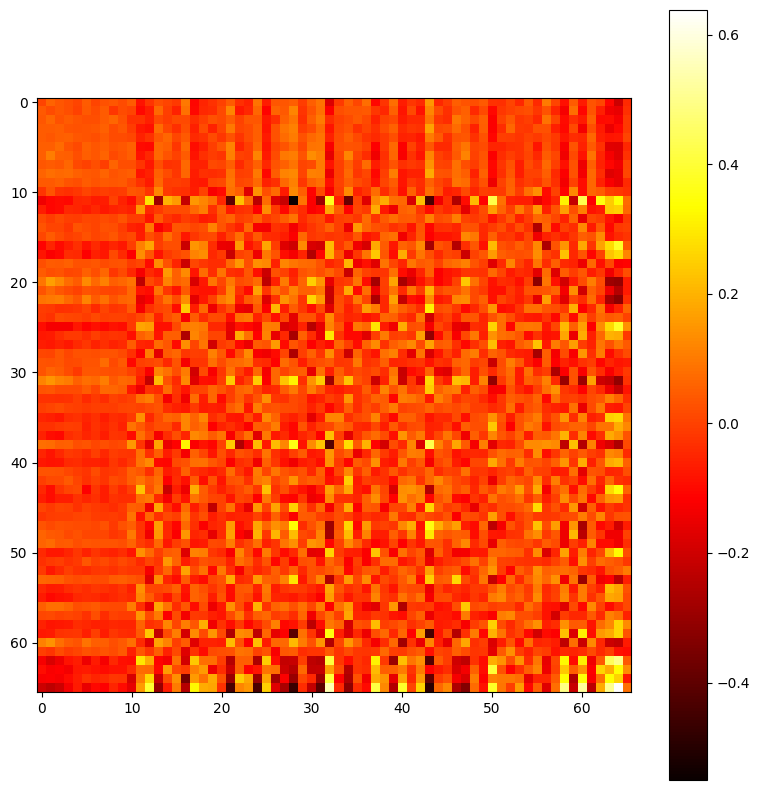

In [107]:
attn = model.blocks[0].attn
all_token_embeddings = model.embed(range(D_VOCAB))

embeddings_key = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                        all_token_embeddings, attn.W_K) 
embeddings_query = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                          all_token_embeddings, attn.W_Q) 
                          
plt.rcParams['figure.figsize'] = [20, 10]
qk_circuit_attn_heatmap = einsum(
    "n_heads d_vocab_q d_head, n_heads d_vocab_k d_head -> ... d_vocab_q d_vocab_k", 
    embeddings_query, embeddings_key
    ).detach().cpu().numpy()
fig, ax = plt.subplots(figsize=(8, 8))
graph = ax.imshow(qk_circuit_attn_heatmap, cmap="hot", interpolation="nearest")
plt.colorbar(graph)
plt.tight_layout()

In [108]:
def calculate_qk_attn_heatmap(model, keypos=-1, querypos=-1):
  attn = model.blocks[0].attn
  all_token_embeddings = model.embed(range(D_VOCAB))
  positional_embeddings = model.pos_embed(all_token_embeddings)

  token_embeddings_at_keypos = all_token_embeddings + positional_embeddings[:,keypos,:] if keypos > -1 else all_token_embeddings
  token_embeddings_at_querypos = all_token_embeddings + positional_embeddings[:,querypos,:] if querypos > -1 else all_token_embeddings

  embeddings_key = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head",
                          token_embeddings_at_keypos, attn.W_K)
  embeddings_query = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head",
                            token_embeddings_at_querypos, attn.W_Q)

  plt.rcParams['figure.figsize'] = [20, 10]
  qk_circuit_attn_heatmap = einsum(
      "n_heads d_vocab_q d_head, n_heads d_vocab_k d_head -> ... d_vocab_q d_vocab_k",
      embeddings_query, embeddings_key
      ).detach().cpu().numpy()

  return qk_circuit_attn_heatmap

def plot_qk_heatmap(model, keypos=-1, querypos=-1):
  qk_attn_heatmap = calculate_qk_attn_heatmap(model, keypos=keypos, querypos=querypos)

  fig, ax = plt.subplots(figsize=(8, 8))
  graph = ax.imshow(qk_attn_heatmap, cmap="hot", interpolation="nearest")
  plt.colorbar(graph)
  plt.tight_layout()

def plot_avg_qk_heatmap(model, keypositions, querypos=-1):
  heatmaps = []

  for keypos in keypositions:
    heatmaps.append(calculate_qk_attn_heatmap(model, keypos=keypos, querypos=querypos))

  qk_circuit_attn_heatmap = np.mean(heatmaps, axis=0)

  fig, ax = plt.subplots(figsize=(8, 8))
  graph = ax.imshow(qk_circuit_attn_heatmap, cmap="hot", interpolation="nearest")
  plt.colorbar(graph)
  plt.tight_layout()

In [109]:
def plot_ov_heatmap(model, pos=-1):
  attn = model.blocks[0].attn
  all_token_embeddings = model.embed(range(D_VOCAB))

  token_embeddings_at_pos = all_token_embeddings + model.pos_embed(all_token_embeddings)[:,pos,:] if pos > -1 else all_token_embeddings

  embeddings_value = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head",
                          token_embeddings_at_pos, attn.W_V)

  embeddings_out = einsum("n_heads d_vocab d_model1, n_heads d_model1 d_model2 -> n_heads d_vocab d_model2",
                        embeddings_value, attn.W_O)

  ov_circuit_attn_heatmap = model.unembed(embeddings_out).detach()

  fig, ax = plt.subplots(figsize=(8, 8))
  graph = ax.imshow(ov_circuit_attn_heatmap[0], cmap="hot", interpolation="nearest")
  plt.colorbar(graph)
  plt.tight_layout()

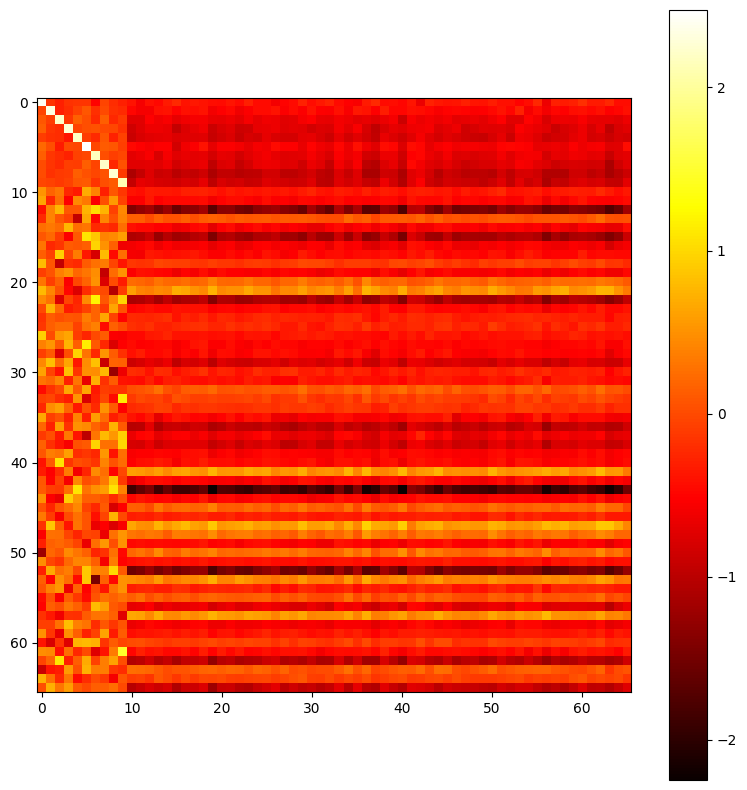

In [110]:
plot_ov_heatmap(model)